In [1]:
import fastf1
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import statsmodels.api as sm
from math import exp
import os
from tqdm import tqdm

/Users/reuben/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


#### Weather & Performance Correlation
Quantify how temperature, humidity & wind direction affect car performance
Build a sensitivity surface for each constructor with visuals

In [2]:
import logging
logging.getLogger("fastf1").setLevel(logging.CRITICAL)

In [3]:
os.makedirs('cache', exist_ok=True)
fastf1.Cache.enable_cache('cache')

In [4]:
# Fetch session
session = fastf1.get_session(2024, 'Silverstone', 'R')
session.load(weather=True, telemetry=False)

laps = session.laps
weather = session.weather_data  # time-indexed weather info
# Convert weather time (timedelta since session start) to absolute timestamp
session_start = session.session_start_time
weather['AbsTime'] = session_start + weather['Time']

In [ ]:
# Extract & merge data
df = pd.merge_asof(
    laps.sort_values('LapStartTime'),
    weather.assign(AbsTime=session_start + weather['Time']).sort_values('AbsTime'),
    left_on='LapStartTime', right_on='AbsTime',
    direction='nearest', tolerance=pd.Timedelta('1min')
)[['Driver', 'Team', 'LapTime', 'AirTemp', 'Humidity', 'TrackTemp']]

df['LapTime_s'] = df['LapTime'].dt.total_seconds()
df.head()

/var/folders/vk/yxskvl4x63dbqzfj_xfn_wvw0000gn/T/ipykernel_62572/3174991890.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['LapTime_s'] = df['LapTime'].dt.total_seconds()


,Driver,Team,LapTime,AirTemp,Humidity,TrackTemp,LapTime_s
0,VER,Red Bull Racing,0 days 00:01:41.657000,NaN,NaN,NaN,101.657
1,GAS,Alpine,0 days 00:01:44.426000,NaN,NaN,NaN,104.426
2,PER,Red Bull Racing,0 days 00:01:46.074000,NaN,NaN,NaN,106.074
3,OCO,Alpine,0 days 00:01:56.745000,NaN,NaN,NaN,116.745
4,ZHO,Kick Sauber,0 days 00:01:49.473000,NaN,NaN,NaN,109.473


In [6]:
# Muliple races
races = [
    ('Bahrain', 'R'),
    ('Jeddah', 'R'),
    ('Melbourne', 'R'),
    ('Miami', 'R'),
    ('Barcelona', 'R'),
    ('Silverstone', 'R'),
    ('Hungaroring', 'R'),
    ('Monza', 'R'),
    ('Singapore', 'R'),
    ('Austin', 'R')
]

all_laps = []

for circuit, session_type in tqdm(races):
    try:
        s = fastf1.get_session(2024, circuit, session_type)
        s.load(weather=True, telemetry=False)

        laps = s.laps[['Driver', 'Team', 'LapTime', 'LapStartTime']].copy()
        weather = s.weather_data.copy()
        weather['AbsTime'] = s.session_start_time + weather['Time']

        merged = pd.merge_asof(
            laps.sort_values('LapStartTime'),
            weather.sort_values('AbsTime'),
            left_on='LapStartTime', right_on='AbsTime',
            direction='nearest', tolerance=pd.Timedelta('1min')
        )

        merged['LapTime_s'] = merged['LapTime'].dt.total_seconds()
        merged['Circuit'] = circuit
        all_laps.append(
            merged[['Circuit', 'Team', 'Driver', 'LapTime_s', 'AirTemp', 'Humidity', 'TrackTemp']]
        )
    except Exception as e:
        print(f"Exception: {circuit}: {e}")

df_all = pd.concat(all_laps, ignore_index=True).dropna(subset=['AirTemp'])
df_all.head()

100%|██████████| 10/10 [06:01<00:00, 36.10s/it]


,Circuit,Team,Driver,LapTime_s,AirTemp,Humidity,TrackTemp
0,Bahrain,Red Bull Racing,VER,97.284,18.9,46.0,26.5
1,Bahrain,Ferrari,LEC,98.271,18.9,46.0,26.5
2,Bahrain,Mercedes,RUS,99.228,18.9,46.0,26.5
3,Bahrain,McLaren,NOR,102.168,18.9,46.0,26.5
4,Bahrain,Mercedes,HAM,103.122,18.9,46.0,26.5


In [7]:
# Clean & aggregate
agg = (df_all
       .groupby(['Circuit', 'Team'])
       .agg({'LapTime_s': 'mean',
             'AirTemp': 'mean',
             'Humidity': 'mean',
             'TrackTemp': 'mean'})
       .reset_index())

/Users/reuben/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/reuben/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/reuben/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/reuben/Library/Python/3.9/lib/python/site-packages/seabo

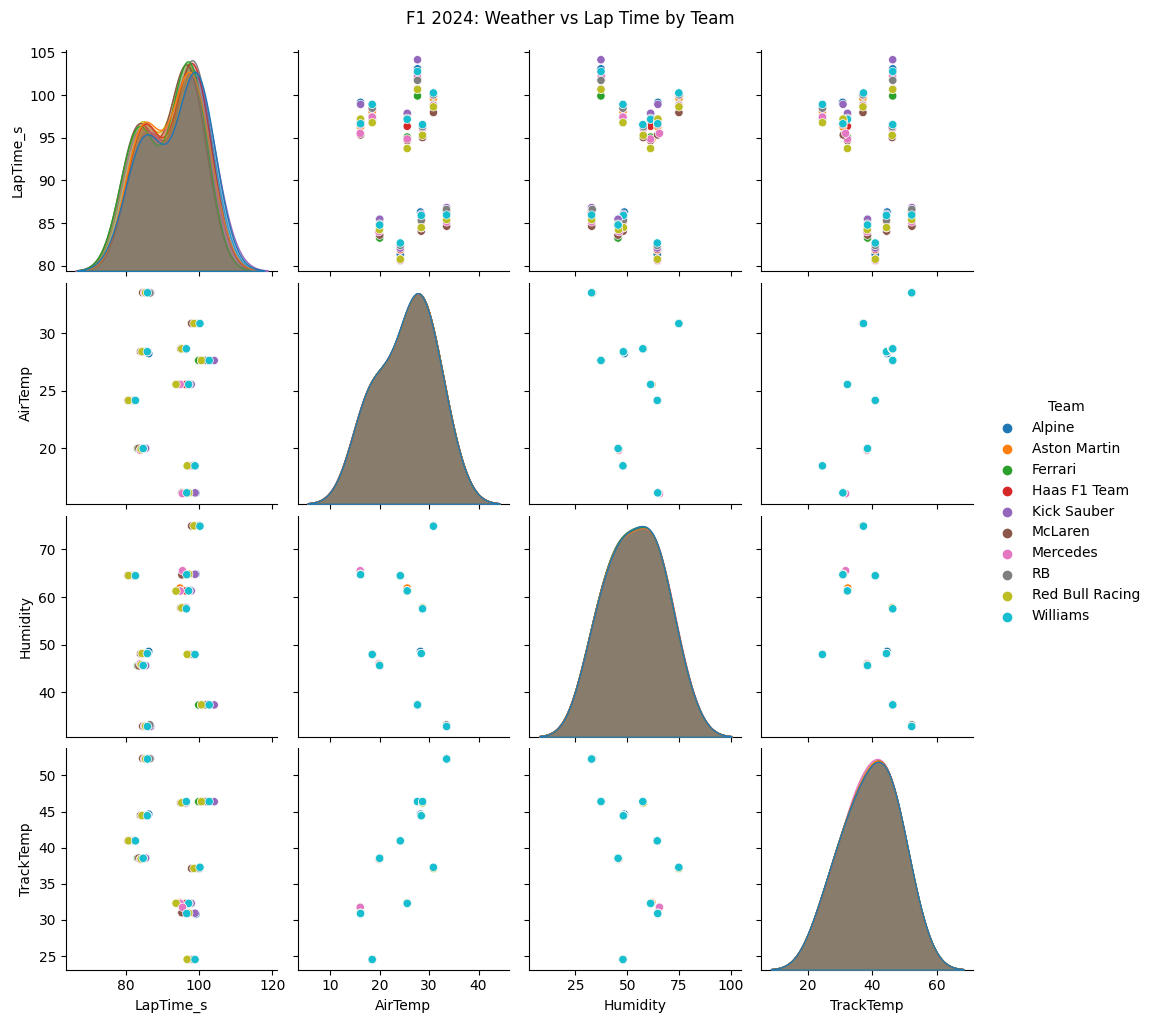

In [8]:
# Pairwise correlation plot for initial diagnostic & visualization
sns.pairplot(agg, vars=['LapTime_s','AirTemp','Humidity','TrackTemp'],
             kind='scatter', diag_kind='kde', hue='Team')
plt.suptitle('F1 2024: Weather vs Lap Time by Team', y=1.02)
plt.show()

/Users/reuben/Library/Python/3.9/lib/python/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/reuben/Library/Python/3.9/lib/python/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/reuben/Library/Python/3.9/lib/python/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


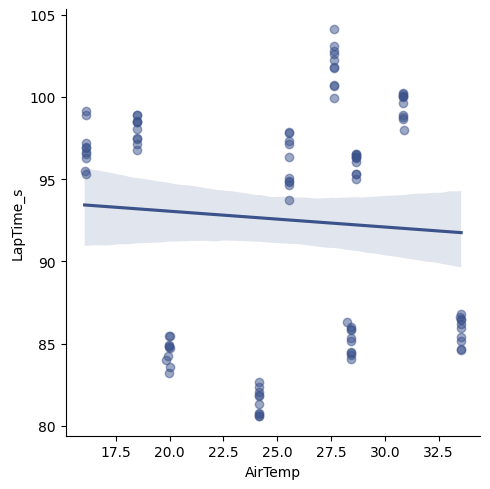

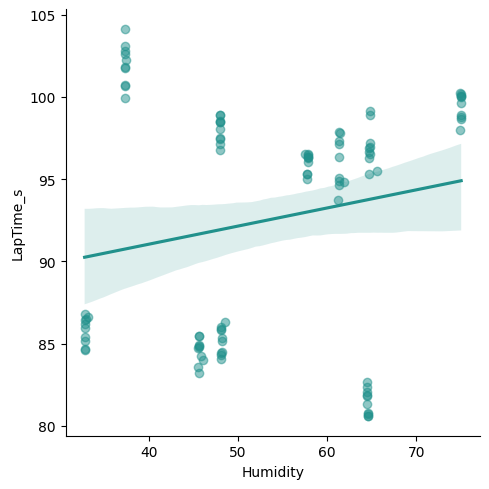

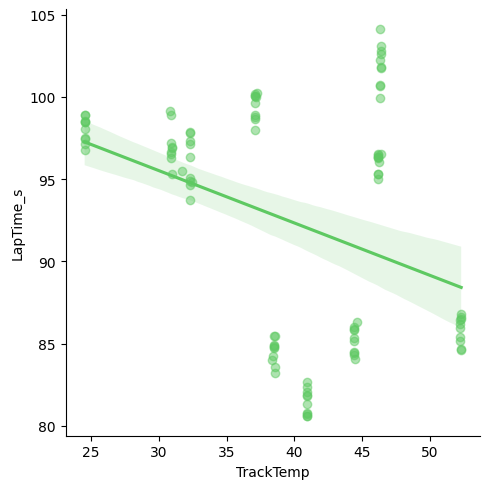

In [9]:
# Aggregate across teams to plot global trend
features = ['AirTemp', 'Humidity', 'TrackTemp']
palette = sns.color_palette('viridis', n_colors=len(features))

for i, feature in enumerate(['AirTemp','Humidity','TrackTemp']):
    sns.lmplot(
        data=agg, x=feature, y='LapTime_s',
        line_kws={'color': palette[i]},
        scatter_kws={'color': palette[i], 'alpha': 0.5}
    )

In [10]:
# Leverage PCA on collective weather-related variables

# Standardize features
features = ['AirTemp', 'Humidity', 'TrackTemp']
X = agg[features]
X_scaled = StandardScaler().fit_transform(X)

# Run PCA
pca = PCA(n_components=3)
components = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(components, columns=['PC1','PC2','PC3'])
pca_df = pd.concat([agg[['Team','Circuit','LapTime_s']], pca_df], axis=1)

explained = pca.explained_variance_ratio_
print(f"Explained variance: {explained.round(3)}")

Explained variance: [0.663 0.279 0.058]


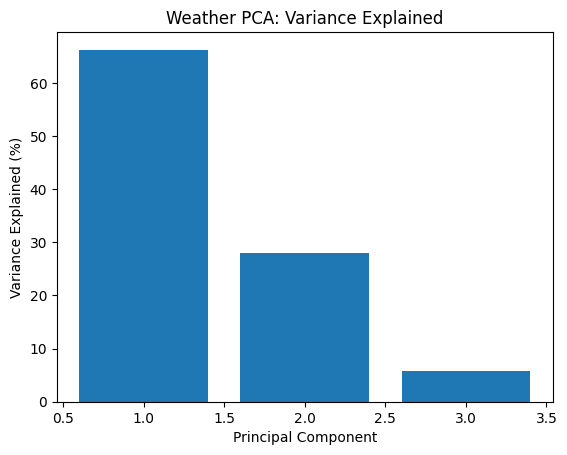

In [11]:
plt.bar(range(1,4), explained*100)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained (%)')
plt.title('Weather PCA: Variance Explained')
plt.show()

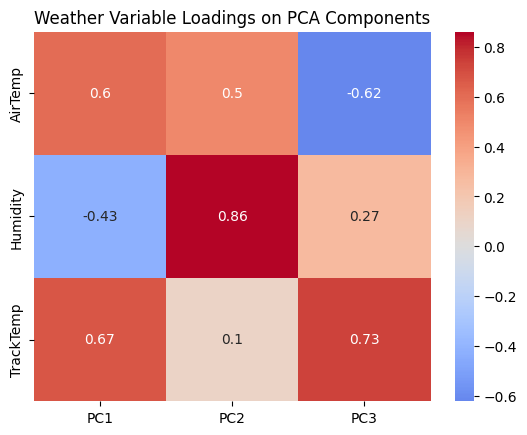

In [12]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=['PC1','PC2','PC3'],
    index=features
)
sns.heatmap(loadings, annot=True, cmap='coolwarm', center=0)
plt.title('Weather Variable Loadings on PCA Components')
plt.show()

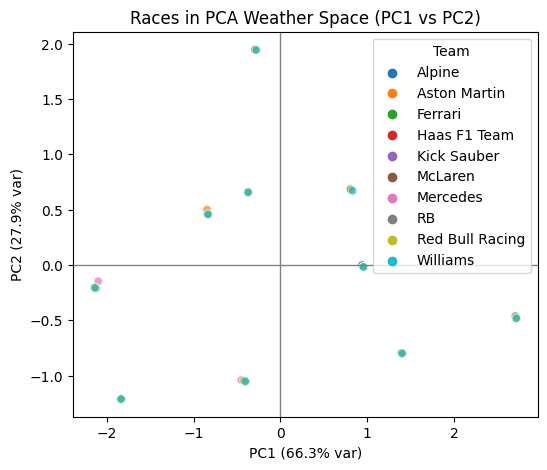

In [13]:
plt.figure(figsize=(6,5))
sns.scatterplot(
    data=pca_df,
    x='PC1', y='PC2',
    hue='Team', palette='tab10', alpha=0.7
)
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.title('Races in PCA Weather Space (PC1 vs PC2)')
plt.xlabel(f"PC1 ({explained[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({explained[1]*100:.1f}% var)")
plt.show()

In [14]:
X = sm.add_constant(pca_df['PC1'])
model = sm.OLS(pca_df['LapTime_s'], X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              LapTime_s   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     7.166
Date:                Sat, 08 Nov 2025   Prob (F-statistic):            0.00871
Time:                        17:14:51   Log-Likelihood:                -334.36
No. Observations:                 100   AIC:                             672.7
Df Residuals:                      98   BIC:                             677.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         92.5346      0.692    133.676      0.0

In [15]:
## Conclusion: PC1 (dry heat) correlates positively with faster lap times
## - PC1 contributes to 6.8% of lap time explanation (fairly substantial)
## - This is a statistically significant contribution (p=0.009)

#### Race Outcome Simulator
Build a Monte Carlo style outcome simulator using each driver’s estimated pace, randomness, tyre strategy, and safety-car probability to produce probabilistic finishing-position distributions

In [17]:
# Keep only drivers who appear in every circuit
valid_drivers = (
    df_all.groupby('Driver')['Circuit']
    .nunique()
    .loc[lambda s: s == df_all['Circuit'].nunique()]
    .index
)

df = df_all[df_all['Driver'].isin(valid_drivers)]

In [18]:
# Calibrate pooled data
# expects df with ['Circuit','Team','Driver','LapTime_s']
def calibrate_pace(df, circuit):
    g = (df[df['Circuit'] == circuit]
         .groupby(['Driver'])['LapTime_s']
         .agg(['mean', 'std'])
         .reset_index())
    g.columns = ['Driver', 'mu', 'sigma']

    # fallback for sparse laps
    g['sigma'] = g['sigma'].fillna(g['sigma'].median())

    return g.set_index('Driver')

In [21]:
# Simple linear tyre/fuel curves

def tyre_deg(lap_on_tyre, k=0.035):
    # secs added per lap on tyre
    return k * lap_on_tyre

def fuel_effect(lap, total_laps, drop=1.8):
    # linear fuel burn weight benefit from lap 1 to last (drop seconds total)
    return drop * (1 - lap/total_laps)

In [22]:
# Overtake & safety car primitives

def pass_prob(pace_delta, delta=0.25, a=2.5):
    # pace_delta = behind_car_laptime - ahead_car_laptime (positive -> faster behind)
    return 1 / (1 + exp(-a * (pace_delta - delta)))

def sc_generator(total_laps, lam=0.02, mean_len=4):
    # returns a boolean array of SC laps
    sc = np.zeros(total_laps, dtype=bool)
    t = 0
    rng = np.random.default_rng()
    while t < total_laps:
        if rng.random() < lam:    # SC starts
            L = max(1, int(rng.exponential(mean_len)))
            sc[t:min(t+L, total_laps)] = True
            t += L
        else:
            t += 1
    return sc

In [23]:
# Parameters assumed & sources:
## k=0.035 seconds per lap added for tyre degradation
## drop=1.8 seconds benefit total from first to last lap as fuel weight depletes
## delta=0.25 minimum pace advantage needed before overtake probability exceeds 50%
### pace equivalent to DRS (Drag Reduction System) benefit
## a=2.5 controls steepness of log distribution of overtakes
## lam=0.02 per-lap probability of safety car period initiating
## mean_len=4 duration (laps) of safety car period

In [27]:
# Simulate a race

def simulate_race(grid, pace_tbl, total_laps=52,
                  pit_windows={'MED':(12,22),'HARD':(28,42)},
                  pit_loss=20.0, pit_loss_sc=12.0,
                  lam_sc=0.02, mean_sc=4, rng=None):
    """
    grid: list of drivers from P1..Pn
    pace_tbl: DataFrame index=Driver with columns ['mu','sigma']
    returns finishing order list
    """
    rng = np.random.default_rng() if rng is None else rng
    n = len(grid)
    # per-car state
    tyre = {d:'MED' for d in grid}
    stint_laps = {d:0 for d in grid}
    pitted = {d:False for d in grid}

    order = grid[:]  # running order
    sc_laps = sc_generator(total_laps, lam_sc, mean_sc)

    for lap in range(1, total_laps+1):
        # pit decisions
        for d in order:
            if not pitted[d]:
                lo, hi = pit_windows['MED']
                will_pit = (lap>=lo and lap<=hi and rng.random()<0.12) or (lap==hi)
                if will_pit:
                    pitted[d] = True
                    tyre[d] = 'HARD'
                    stint_laps[d] = 0
                    # apply pit time penalty as a “mega lap”
                    # (simplified: add to this lap's time later via +pit_pen)
                    pace_tbl.loc[d,'mu'] += 0  # keep base μ; penalty added below

        # lap times
        times = {}
        for d in order:
            base = pace_tbl.loc[d,'mu']
            eps  = rng.normal(0, pace_tbl.loc[d,'sigma'])
            td   = tyre_deg(stint_laps[d], k=0.035 if tyre[d]=='MED' else 0.02)
            fuel = fuel_effect(lap, total_laps, drop=1.8)
            pit_pen = 0.0
            # if pitted this lap, apply penalty
            if pitted[d] and stint_laps[d]==0 and lap>1:  # crude detection: just pitted
                pit_pen = (pit_loss_sc if sc_laps[lap-1] else pit_loss)
            sc_add = 8.0 if sc_laps[lap-1] else 0.0  # slow SC train
            times[d] = base + td - fuel + eps + pit_pen + sc_add
            stint_laps[d] += 1

        # sort by lap time to get "raw pace" order this lap
        pace_rank = sorted(order, key=lambda d: times[d])

        # overtaking: iterate from P2 backwards; try pass if faster than car ahead
        new_order = order[:]
        for i in range(1, n):
            me = order[i]
            ahead = order[i-1]
            if sc_laps[lap-1]:  # overtakes nearly frozen
                continue
            delta = times[ahead] - times[me]  # >0 means I'm faster
            if rng.random() < pass_prob(delta):
                # swap positions
                j = new_order.index(me)
                new_order[j-1], new_order[j] = new_order[j], new_order[j-1]
        order = new_order

    return order

In [28]:
# Run many simulations to get position distributions

def monte_carlo(circuit, grid, df_all, sims=2000, total_laps=52, lam_sc=0.02, mean_sc=4):
    pace = calibrate_pace(df_all, circuit)
    counts = {d:np.zeros(len(grid), dtype=int) for d in grid}
    rng = np.random.default_rng()

    for _ in range(sims):
        fin = simulate_race(grid, pace.copy(), total_laps, lam_sc=lam_sc, mean_sc=mean_sc, rng=rng)
        for pos, d in enumerate(fin):
            counts[d][pos] += 1

    dist = (pd.DataFrame({d: c/float(sims) for d,c in counts.items()})
              .T.rename(columns=lambda k: f'P{k+1}'))
    dist['Win%'] = (dist['P1']*100).round(1)
    dist['Podium%'] = (dist[['P1','P2','P3']].sum(axis=1)*100).round(1)
    return dist.sort_values('Win%', ascending=False)

In [ ]:
# Main execution
# In qualifying order:

grid = (
    df.sort_values('GridPos')        # smallest grid position first
      .drop_duplicates('Driver')     # keep one row per driver
      ['Driver']
      .tolist()
)

grid = [d for d in grid if d in df['Driver'].unique()]

dist = monte_carlo('Silverstone', grid, df, sims=1000, total_laps=52, lam_sc=0.03, mean_sc=5)
dist.head(10)

KeyError: 'GridPos'

Index(['Driver', 'Team', 'LapTime', 'LapStartTime', 'Time', 'AirTemp',
       'Humidity', 'Pressure', 'Rainfall', 'TrackTemp', 'WindDirection',
       'WindSpeed', 'AbsTime'],
      dtype='object')

In [37]:
# Main execution

grid_df = (
    session.results[['Abbreviation', 'GridPosition']]
    .rename(columns={'Abbreviation': 'Driver', 'GridPosition': 'GridPos'})
    .sort_values('GridPos')
)

df = (
    pd.merge_asof(
        laps.sort_values('LapStartTime'),
        weather.assign(AbsTime=session_start + weather['Time']).sort_values('AbsTime'),
        left_on='LapStartTime',
        right_on='AbsTime',
        direction='nearest',
        tolerance=pd.Timedelta('1min')
    )
    .merge(grid_df, on='Driver', how='left')
    [['Driver', 'Team', 'LapTime', 'AirTemp', 'Humidity', 'TrackTemp', 'GridPos']]
)
df['LapTime_s'] = df['LapTime'].dt.total_seconds()

grid = grid_df.loc[grid_df['Driver'].isin(df['Driver']), 'Driver'].tolist()

dist = monte_carlo('Silverstone', grid, df, sims=1000, total_laps=52,
                   lam_sc=0.03, mean_sc=5)
dist.head(10)

KeyError: 'Circuit'